# Assignment 5 - Tamim Shaban

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')

### Load Data

In [3]:
df = pd.read_csv("HR-Employee-Attrition.csv")

In [4]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## Q1 - Data Visualization and Investigation

### Data Visualization

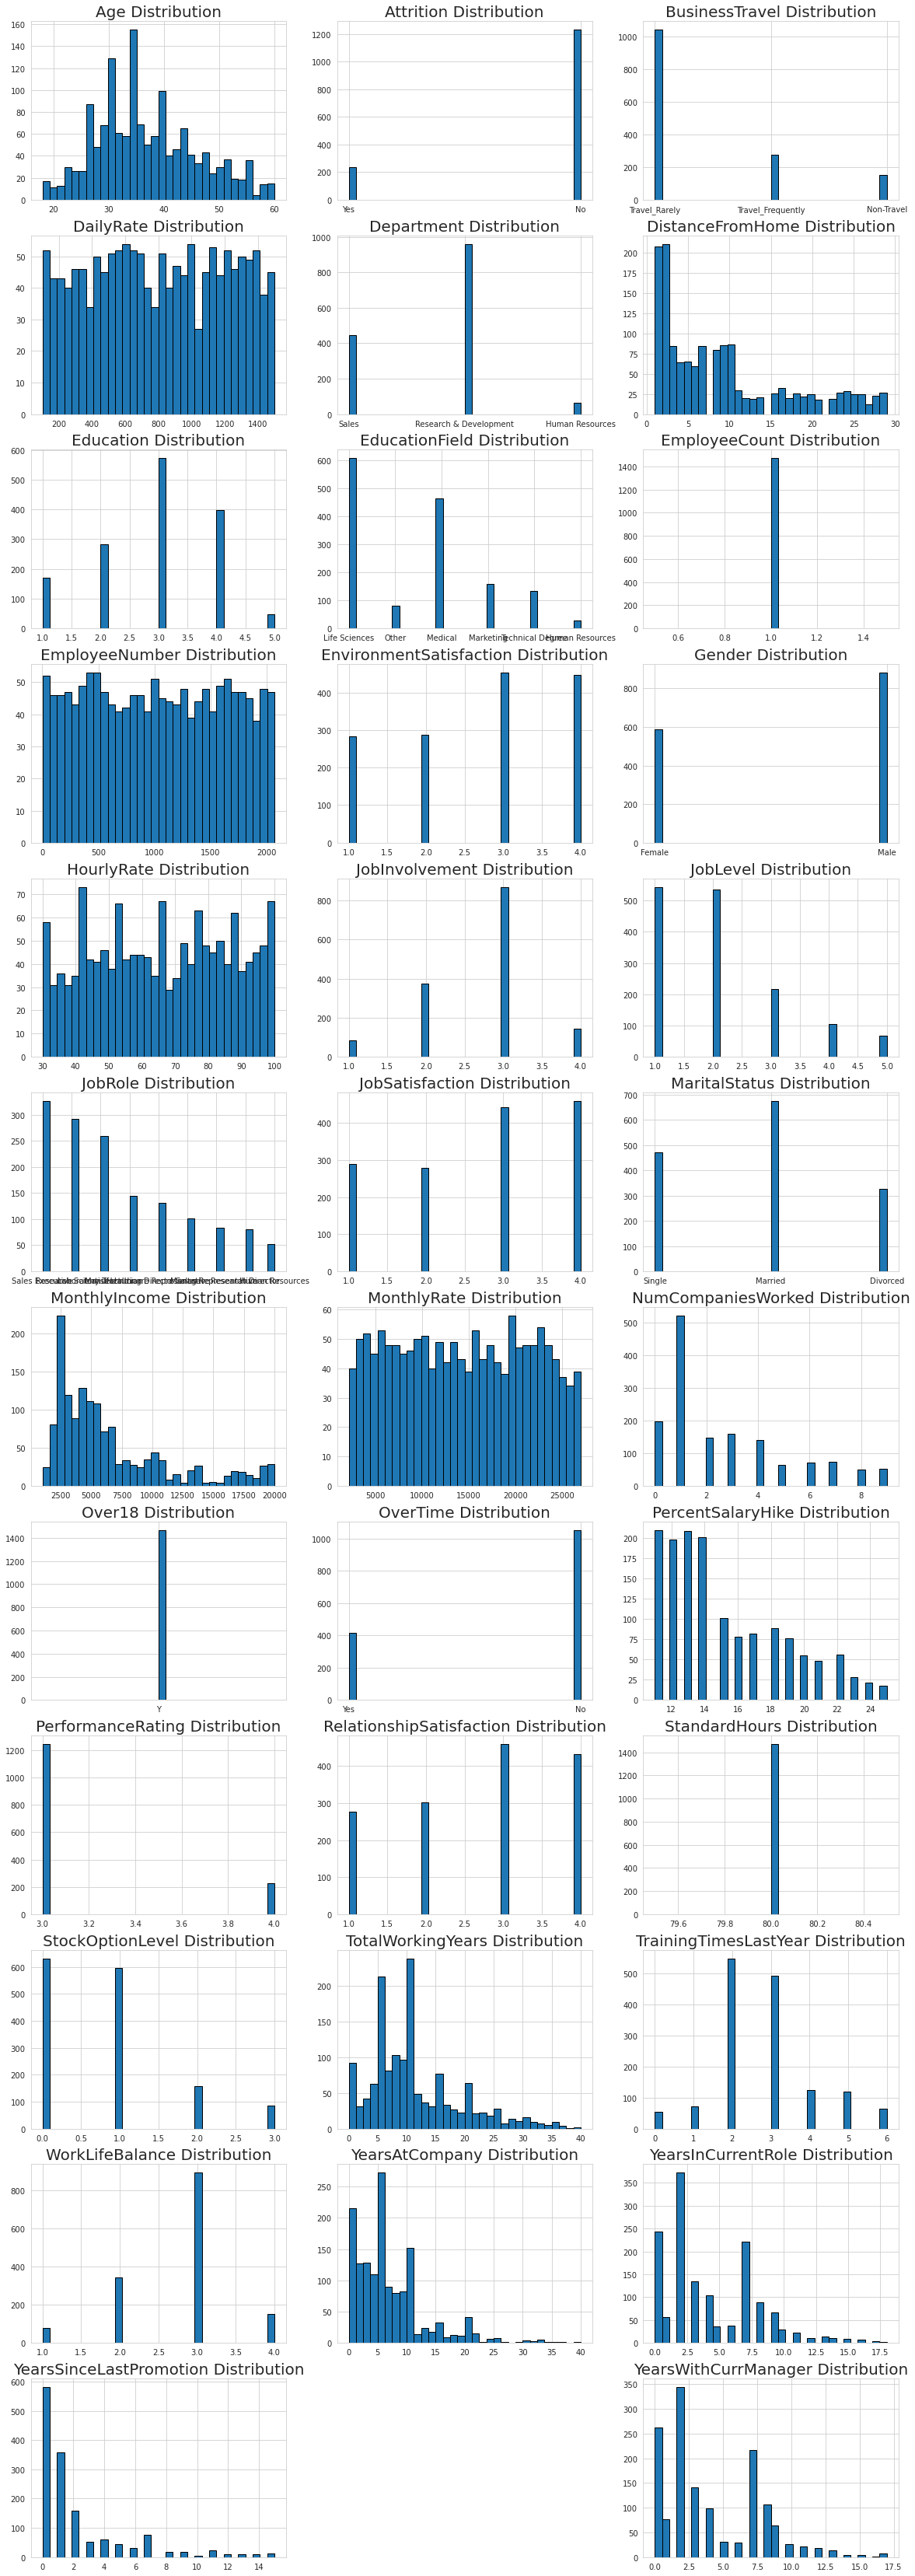

In [5]:
fig = plt.figure(figsize=(20, 60))
gs = gridspec.GridSpec(12,3)
for index, col in enumerate(list(df.columns)):
    index = index+1 if index == len(list(df.columns))-1 else index
    ax = plt.subplot(gs[index])
    ax.hist(df[col], bins=32, edgecolor='black')
    ax.set_title(col+" Distribution", fontdict={'fontsize':20})

#### Observations

Over18 and StandardHours have only a single value for all rows. This means they won't contribute to our model's ability to discriminate between data and so I'll remove them from the feature list.

Attrition, BusinessTravel, Department, EducationField, Gender, JobRole, MatritalStatus, OverTime are all categorical data represented by strings. We'll need to adjust the binary categories into 1s and 0s insted of strings and split the multicatigorical data into many binary categories of 1s and 0s.

Many features such as MonthlyIncome have large values that will skrew our optimizer and so we must first normalize them before training.

Many features are represented by other features and so they aren't linearly independent. For example DailyRate, HourlyRate, MonthlyRate, and MonthlyIncome have simliar distriubtion and probably correlate with one another. We don't need an over representation of these features in the model so we must remove some.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

### Atrribute Converstion

#### Converting features

In [7]:
# Gender(Male, Female) -> Male(1, 0)
gender = pd.get_dummies(df['Gender'],drop_first=True)
# Overtime (Yes, No) -> Yes(1, 0)
overTime = pd.get_dummies(df['OverTime'],drop_first=True).rename(columns={"Yes": "OverTime"})
# MatricalStatus (Single, Married) -> Single(1, 0)
maritalStatus = pd.get_dummies(df['MaritalStatus'],drop_first=True).drop(['Married'], axis=1)
# BusinessTravel (Travel_Frequently, Travel_Rarely) -> Travel_Frequently(1, 0)
businessTravel = pd.get_dummies(df['BusinessTravel'],drop_first=True).drop(['Travel_Rarely'], axis=1)
#  Department (Research & Development, Sales) -> Sales(1, 0)
department = pd.get_dummies(df['Department'],drop_first=True).drop(['Research & Development'], axis=1)
# EducationField (Life Sciences, Marketing, Medical, Other, Techincal Degree) ->
#       Life Sciences(1,0) , Marketing(1,0) , Medical(1,0) , Other(1,0) , Techincal Degree(1,0) 
educationField = pd.get_dummies(df['EducationField'],drop_first=True)
jobRole = pd.get_dummies(df['JobRole'],drop_first=True)
attrition = pd.get_dummies(df['Attrition'],drop_first=True).rename(columns={"Yes": "Attrition"})

#### Dropping columns

In [8]:
# Droping preconverted features
df.drop(['Gender', 'OverTime', 'MaritalStatus', 'BusinessTravel',
         'Department', 'EducationField', 'JobRole', 'Attrition'],axis=1,inplace=True)
# Droping single value features and unique value features
df.drop(['Over18', 'EmployeeNumber', 'EmployeeCount', 'StandardHours'],axis=1,inplace=True)

#### Adding converted features

In [9]:
df = pd.concat([df, gender, overTime, maritalStatus, businessTravel,
                department, educationField, jobRole, attrition],axis=1)

### Data Correllation

<AxesSubplot:>

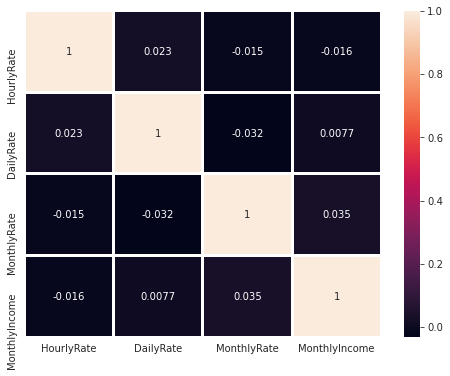

In [10]:
corr_Rate = df[['HourlyRate', 'DailyRate', 'MonthlyRate', 'MonthlyIncome']].corr()
sns.heatmap(corr_Rate,annot=True,linewidths=2)

#### Observation
As suspected, DailyRate, HourlyRate, MonthlyRate, and MonthlyIncome are not linearly independant from one another. As such, we'll remove DailyRate, HourlyRate, and MonthlyRate from the training and testing data.

In [11]:
for col in ['HourlyRate', 'DailyRate', 'MonthlyRate']:
    df.drop([col],axis=1,inplace=True)

### Data Normalization

In [12]:
for col in ['MonthlyIncome', 'Age', 'DistanceFromHome', 'PercentSalaryHike', 'TotalWorkingYears',
           'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']:
    if col in df:
        max_value = df[col].max()
        min_value = df[col].min()
        df[col] = (df[col] - min_value) / (max_value - min_value)

In [13]:
# fig = plt.figure(figsize=(20, 60))
# gs = gridspec.GridSpec(15,3)
# for index, col in enumerate(list(df.columns)):
#     index = index+1 if index == len(list(df.columns))-1 else index
#     ax = plt.subplot(gs[index])
#     ax.hist(df[col], bins=32, edgecolor='black')
#     ax.set_title(col+" Distribution", fontdict={'fontsize':20})

## Q2 - Model Training

### Data Spliting

In [14]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Linear Regression - (Just an experiment)

In [15]:
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)

LinearRegression()

In [16]:
predictions = LinReg.predict(X_test)
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test, predictions))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test, predictions))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Mean absolute error (MAE): 0.24469136495043445
Mean square error (MSE): 0.10396557404454981
Root mean square error (RMSE): 0.32243693033607335


### Logistic Regression - (Model 1)

In [17]:
LogReg = LogisticRegression(max_iter=10000)
LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [18]:
predictions_Log = LogReg.predict(X_test)
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test, predictions_Log))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test, predictions_Log))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test, predictions_Log)))

Mean absolute error (MAE): 22.568027210884352
Mean square error (MSE): 0.1054421768707483
Root mean square error (RMSE): 0.32471861183299655


### Support Vector Machine - (Model 2)

In [19]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [20]:
predictions_SVC = svc.predict(X_test)
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test, predictions_SVC))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test, predictions_SVC))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test, predictions_SVC)))

Mean absolute error (MAE): 23.43877551020408
Mean square error (MSE): 0.11224489795918367
Root mean square error (RMSE): 0.33502969713024494


### Decision Tree - (Model 3)

In [21]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [22]:
predictions_Tree = tree.predict(X_test)
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test, predictions_Tree))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test, predictions_Tree))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test, predictions_Tree)))

Mean absolute error (MAE): 21.82312925170068
Mean square error (MSE): 0.22448979591836735
Root mean square error (RMSE): 0.47380354147934284


## Q3 - Model Testing

### (A) Confusion Matrix

#### Logistic Regression - (Model 1)

In [23]:
confusion_matrix_Log = metrics.confusion_matrix(y_test, predictions_Log)
print(confusion_matrix_Log)
print(metrics.classification_report(y_test, predictions_Log))

[[497  10]
 [ 52  29]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       507
           1       0.74      0.36      0.48        81

    accuracy                           0.89       588
   macro avg       0.82      0.67      0.71       588
weighted avg       0.88      0.89      0.88       588



#### Support Vector Machine - (Model 2)

In [24]:
confusion_matrix_SVC = metrics.confusion_matrix(y_test, predictions_SVC)
print(confusion_matrix_SVC)
print(metrics.classification_report(y_test, predictions_SVC))

[[495  12]
 [ 54  27]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       507
           1       0.69      0.33      0.45        81

    accuracy                           0.89       588
   macro avg       0.80      0.65      0.69       588
weighted avg       0.87      0.89      0.87       588



#### Descision Tree - (Model 3)

In [25]:
confusion_matrix_Tree = metrics.confusion_matrix(y_test, predictions_Tree)
print(confusion_matrix_Tree)
print(metrics.classification_report(y_test, predictions_Tree))

[[425  82]
 [ 50  31]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       507
           1       0.27      0.38      0.32        81

    accuracy                           0.78       588
   macro avg       0.58      0.61      0.59       588
weighted avg       0.81      0.78      0.79       588



#### Observation
Both Model 1 and Model 2 have accuracy that is equally greater than Model 3, however, Model 1 has a better precision and recall score for "Yes" answers than Model 2 does; meaning that Model 1 is less likely is falsely label data as postive.

### (B) ROC curve, AUC value and Gini value

#### Logistic Regression - (Model 1)

Logistic Regression
	AUC:	0.6691504127401564
	Gini:	0.3383008254803128


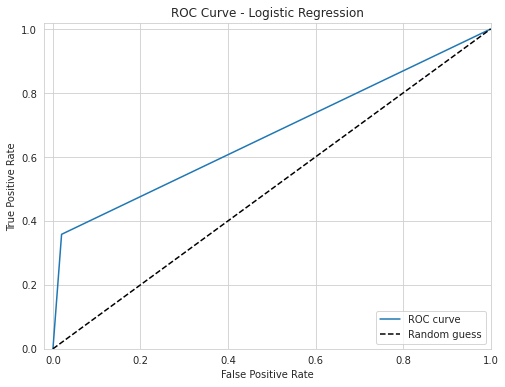

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_Log)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

auc = metrics.auc(fpr, tpr)
gini = 2*auc-1
print(f"Logistic Regression\n\tAUC:\t{auc}\n\tGini:\t{gini}")

#### Support Vector Machine - (Model 2)

Support Vector Machine
	AUC:	0.6548323471400395
	Gini:	0.3096646942800789


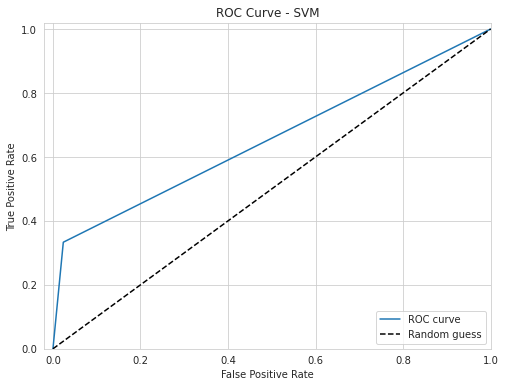

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_SVC)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

auc = metrics.auc(fpr, tpr)
gini = 2*auc-1
print(f"Support Vector Machine\n\tAUC:\t{auc}\n\tGini:\t{gini}")

#### Descision Tree - (Model 3)

Descision Tree
	AUC:	0.6104901745927387
	Gini:	0.22098034918547738


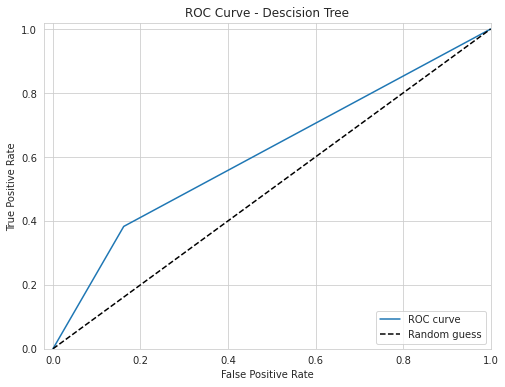

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions_Tree)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Descision Tree')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

auc = metrics.auc(fpr, tpr)
gini = 2*auc-1
print(f"Descision Tree\n\tAUC:\t{auc}\n\tGini:\t{gini}")

#### Observation

All three models have good specificity, however, Model 3 is a bit worse in this regard. Also, all three models have poor sensitivity, meaning they can not reliablly label data as positive. In this case, the models are almost as good as randomly guessing if something is label positive.